In [1]:
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

Relative imports are confusing, and I only have three functions anyway.

In [2]:
def postcodes_to_latlong(df: pd.DataFrame):
    spatial = pd.read_excel("../initial_docs/inspost.xls")
    spatial.drop(columns=["INS", "COMMUNE"], inplace=True)  # we do not need these info
    tmp_df = pd.merge(df, spatial, how="left", on="CODPOSS")
    tmp_df.drop(columns="CODPOSS", inplace=True)
    
    return tmp_df


def cat_to_numeric(data: pd.DataFrame):
    tmp = data.copy(deep=True)
    
    tmp['agecar'] = tmp['agecar'].map({"0-1": 0, "2-5": 1, "6-10":2, ">10": 3})
    tmp['sexp'] = tmp['sexp'].map({"Male": 0, "Female": 1})
    tmp['fuelc'] = tmp['fuelc'].map({"Petrol": 0, "Gasoil": 1})
    tmp['split'] = tmp['split'].map({"Once": 0, "Monthly": 1, "Twice":2, "Thrice": 3})
    tmp['usec'] = tmp['usec'].map({"Private": 0, "Professional": 1})
    tmp['fleetc'] = tmp['fleetc'].map({"Yes": 0, "No": 1})
    tmp['sportc'] = tmp['sportc'].map({"Yes": 0, "No": 1})
    tmp['coverp'] = tmp['coverp'].map({"MTPL": 0, "MTPL+": 1, "MTPL+++":2})
    tmp['powerc'] = tmp['powerc'].map({"<66": 0, "66-110": 1, ">110":2})
    
    return tmp


def avg_claim(row):
    if row['nbrtotc'] == 0:
        return 0
    else:
        return row['chargtot'] / row['nbrtotc']

Reading data and saved random forests.

In [75]:
test = pd.read_csv("../data/test.csv")
test.rename(columns={"Unnamed: 0": "policy_id"}, inplace=True)
test2 = postcodes_to_latlong(test)
test = cat_to_numeric(test2)

test.head()

,policy_id,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,LAT,LONG
0,85673,55,0.495890,-0.701400,0,0.0,0.000000,1,0,1,0,0,1,1,2,0,50.466667,4.183333
1,136582,46,1.000000,0.000000,1,1.0,145.017712,2,0,0,2,0,1,1,1,0,50.383333,4.683333
2,134719,42,0.509589,-0.674151,0,0.0,0.000000,2,0,0,0,1,1,1,0,0,50.883333,3.433333
3,96680,24,1.000000,0.000000,0,0.0,0.000000,1,0,0,3,0,1,1,0,0,51.216667,2.900000
4,41927,79,1.000000,0.000000,0,0.0,0.000000,3,1,0,3,0,1,1,0,0,50.683333,4.200000


In [65]:
freq_rf = joblib.load("../models/freq_rf.pkl")
sev_rf = joblib.load("../models/sev_rf.pkl")

features = freq_rf_final.feature_names_in_  # needed features will be here

# Analyzing the tariff-plan

## Grabbing random forest predictions

In [66]:
test_rf_freq_preds = freq_rf.predict(test.loc[:, features]) * test.loc[:, "duree"]  # account for exposure as well!
test_rf_sev_preds = sev_rf.predict(test.loc[:, features])

In [76]:
rf_preds = test.loc[:, ["policy_id", "nbrtotc", "chargtot"]]  # to get zeroes first
rf_preds['avg_claim'] = rf_preds.apply(lambda row: avg_claim(row), axis=1)

rf_preds['rf_freq_preds'] = test_rf_freq_preds
rf_preds['rf_sev_preds'] = test_rf_sev_preds
rf_preds['rf_tariff_preds'] = rf_preds['rf_freq_preds']*rf_preds['rf_sev_preds']

rf_preds = rf_preds.iloc[:, [0, 1, 3, 2, 4, 5, 6]]
rf_preds.query("nbrtotc > 1")[0:6]

,policy_id,nbrtotc,avg_claim,chargtot,rf_freq_preds,rf_sev_preds,rf_tariff_preds
24,127335,2,883.975915,1767.951829,0.168462,1466.489643,247.047585
29,152691,2,278.582743,557.165486,0.127129,1734.311468,220.480613
69,125512,2,158.676645,317.353290,0.140678,1963.060437,276.158837
126,128996,2,384.495252,768.990503,0.152646,1229.984087,187.751719
154,94059,2,840.842441,1681.684883,0.162941,1665.337240,271.352438
261,54438,2,126.004279,252.008557,0.162606,1569.615446,255.229655


## Grabbing glm predictions

In [77]:
glm_preds = pd.read_csv("../data/glm_tariff_preds.csv")
glm_preds.drop(columns="Unnamed: 0", inplace=True)  # should have saved without index before
glm_preds.rename(columns={"freq": "glm_freq_preds",
                          "sev": "glm_sev_preds",
                          "tariff": "glm_tariff_preds"}, inplace=True)
glm_preds.head()

,policy_id,glm_freq_preds,glm_sev_preds,glm_tariff_preds
0,105596,0.050836,1518.758577,77.207544
1,21635,0.142176,1118.215836,158.983557
2,70855,0.025340,2189.930542,55.493073
3,64035,0.038247,1671.078165,63.914370
4,54825,0.275049,1925.478569,529.601083


In [78]:
test_preds = pd.merge(rf_preds, glm_preds, how="left", on="policy_id")  # no collision => no need for suffixes  
test_preds.head()

,policy_id,nbrtotc,avg_claim,chargtot,rf_freq_preds,rf_sev_preds,rf_tariff_preds,glm_freq_preds,glm_sev_preds,glm_tariff_preds
0,85673,0,0.000000,0.000000,0.066165,1415.451155,93.653873,0.053009,929.476850,49.270397
1,136582,1,145.017712,145.017712,0.148701,1482.844596,220.500101,0.101324,2860.375688,289.823360
2,134719,0,0.000000,0.000000,0.067501,1822.718809,123.036028,0.050308,2928.621134,147.334062
3,96680,0,0.000000,0.000000,0.144133,1767.660562,254.778899,0.242217,1376.119000,333.319294
4,41927,0,0.000000,0.000000,0.123240,1639.260475,202.021995,0.152415,1256.646341,191.531954


## Combine both predictions with the test set

Drop *nbrtotc* and *chargtot* so that we can merge *test* (with covariate infos) with *test_preds* without any collision.

In [79]:
test_preds.drop(columns=["nbrtotc", "chargtot"], inplace=True)
combined_preds = pd.merge(test, test_preds, how="left", on="policy_id")
combined_preds.head(3)

,policy_id,AGEPH,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,...,powerc,LAT,LONG,avg_claim,rf_freq_preds,rf_sev_preds,rf_tariff_preds,glm_freq_preds,glm_sev_preds,glm_tariff_preds
0,85673,55,0.495890,-0.701400,0,0.0,0.000000,1,0,1,...,0,50.466667,4.183333,0.000000,0.066165,1415.451155,93.653873,0.053009,929.476850,49.270397
1,136582,46,1.000000,0.000000,1,1.0,145.017712,2,0,0,...,0,50.383333,4.683333,145.017712,0.148701,1482.844596,220.500101,0.101324,2860.375688,289.823360
2,134719,42,0.509589,-0.674151,0,0.0,0.000000,2,0,0,...,0,50.883333,3.433333,0.000000,0.067501,1822.718809,123.036028,0.050308,2928.621134,147.334062


## Ratio of $\frac{\texttt{sum(tariff)} - \texttt{sum(chargtot)}}{\texttt{sum(chargtot)}}$

Based on the test set, we over-predicted the tariffs compared to the total claims. GLM's over-prediction, however, is closer to the actual total claims compared to RF. In the SAJ-GAM paper, the GLM over-predicted by $12.9\%$, so I think my results were pretty good.

In [88]:
sum_rf_tariff = combined_preds["rf_tariff_preds"].sum()
sum_glm_tariff = combined_preds["glm_tariff_preds"].sum()
sum_chargtot = combined_preds["chargtot"].sum()

print(f"The total claim is {round(sum_chargtot, 0)} euros.")
print("------------------------------------------------------------------------------------------")
print(f"The total tariffs predicted by random forest is {round(sum_rf_tariff, 0)} euros.")
print(f"Predicted {round(sum_rf_tariff-sum_chargtot, 0)} euros over the total claims.")
print("------------------------------------------------------------------------------------------")
print(f"The total tariffs predicted by glm is {round(sum_glm_tariff, 0)} euros.")
print(f"Predicted {round(sum_glm_tariff-sum_chargtot, 0)} euros over the total claims.")

print("------------------------------------------------------------------------------------------")
print(f"RF has a ratio of {round(sum_rf_tariff/sum_chargtot, 3) - 1} while GLM has a ratio of {round(sum_glm_tariff/sum_chargtot, 3) - 1}")

The total claim is 5962054.0 euros.
------------------------------------------------------------------------------------------
The total tariffs predicted by random forest is 6858919.0 euros.
Predicted 896866.0 euros over the total claims.
------------------------------------------------------------------------------------------
The total tariffs predicted by glm is 6680576.0 euros.
Predicted 718522.0 euros over the total claims.
------------------------------------------------------------------------------------------
RF has a ratio of 0.1499999999999999 while GLM has a ratio of 0.121


The two plots below shows that rf tends to price the tariffs higher compared to glm. The wing on the rf plot is located higher compared to glm's. Most policy holders are paying aroudn the 200euros range, while for GLM most policyholders are paying below the 200euros range. 

The long tail of glm seems to indicate that the risk is somewhat more personalized compared to rf, a certain combination of risk class is paying a very high premium. This is likely due to the presence of extreme outliers in the *avg_claim* feature (perhaps a certain combination of risk class results in only very few policyholders, and one of them only had one accident: totaled their car. This significantly effects the responsible coefficient). In rf, when fitting in for severity, I set the minimum number of policyholders per node as $1\% \approx 180$ policyholders, and then we take the average on said node, so this somewhat mitigated the effect of the extreme outlier.

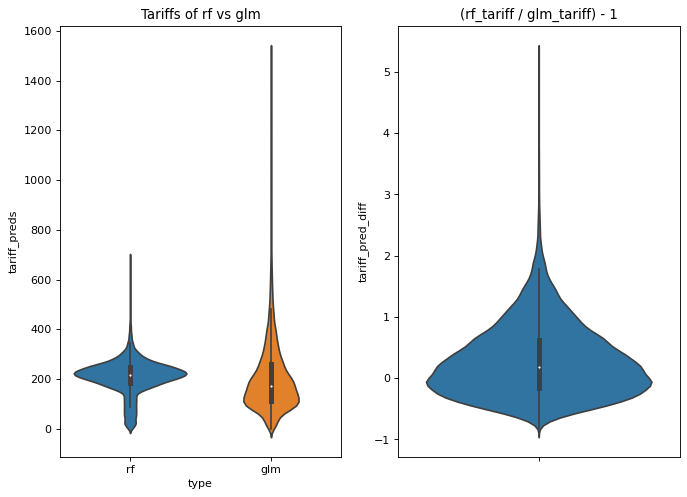

In [122]:
tmp_rf_tariff = combined_preds.loc[:, ["rf_tariff_preds"]]
tmp_rf_tariff.insert(1, "type", "rf")
tmp_rf_tariff.rename(columns={"rf_tariff_preds": "tariff_preds"}, inplace=True)
tmp_glm_tariff = combined_preds.loc[:, ["glm_tariff_preds"]]
tmp_glm_tariff.insert(1, "type", "glm")
tmp_glm_tariff.rename(columns={"glm_tariff_preds": "tariff_preds"}, inplace=True)

tmp_violin_df = pd.concat([tmp_rf_tariff, tmp_glm_tariff], axis=0)

plt.figure(figsize=(10, 7), dpi=80)
plt.subplot(1, 2, 1)
sns.violinplot(x=tmp_violin_df["type"] ,y=tmp_violin_df["tariff_preds"]).set(title="Tariffs of rf vs glm");

################################################################################################
combined_preds["tariff_pred_diff"] = (combined_preds["rf_tariff_preds"] - combined_preds["glm_tariff_preds"]) / combined_preds["glm_tariff_preds"]

plt.subplot(1, 2, 2)
sns.violinplot(y=combined_preds["tariff_pred_diff"]).set(title="(rf_tariff / glm_tariff) - 1");

The right hand plot above also tells an interesting story, it is not centered at 0, reaffirming that rf does tend to overprice the premiums compared to glm. Below are the quartiles of the difference. $63.1\%$ of policyholders would pay more under rf compared to glm.

In [126]:
combined_preds["tariff_pred_diff"].quantile(q=[0.25, 0.5, 0.75])

0.25   -0.154861
0.50    0.183738
0.75    0.623382
Name: tariff_pred_diff, dtype: float64

In [133]:
diff_more_than_zero = combined_preds.loc[combined_preds["tariff_pred_diff"] > 0, ["tariff_pred_diff"]]

more_than_zero = 100*diff_more_than_zero.shape[0]/combined_preds.shape[0]
print(f"{round(more_than_zero, 1)}% of policyholders would pay more with rf premiums compared to glm premiums.")

63.1% of policyholders would pay more with rf premiums compared to glm premiums.
